# [Bacterial Colony Growth](@id Bacteries)

In this example, we are going to create a bacterial model and grow a colony using it.

 - The implementation of the force interaction dynamics is the one presented by [Volfson et al. (2008)](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105)
 - We use GPU accelerated dynamics

As described in other models, it is advised that the models are constructed by parts to avoid having to find bugs in a very complex system. Hence, we will split the model in two parts:

 - Forces model
 - Growth model

## Load the packages

In [2]:
using Base.Threads
println("Usando ", nthreads(), " threads 😎")

Usando 1 threads 😎


In [3]:
# import Pkg
# Pkg.activate("../")
# Pkg.instantiate()


In [4]:
# import Pkg; Pkg.add(["Revise", "GLMakie"])

In [5]:
# using Revise
# using CellBasedModels
# using CUDA
# using Distributions
# using GLMakie
# # using GeometryBasics
# import GLMakie: Point3f, Cylinder, Sphere, NoShading #Can be changes to Cairo or CLMakie

In [6]:
import Pkg

# Activa el entorno del proyecto
Pkg.activate("../../../")

# Pkg.rm("GLMakie")

# Resuelve y asegura dependencias
Pkg.resolve()
Pkg.instantiate()

# Evita errores de versiones incompatibles forzando actualización
# Pkg.update(["CairoMakie", "Revise", "CUDA", "Distributions"])

# Carga los paquetes de forma ordenada
using Revise
using CellBasedModels
using CUDA
using Distributions
using CairoMakie
using JSON

# Importa funciones específicas después
import CairoMakie: Point3f, Cylinder, Sphere, NoShading

CairoMakie.activate!()


  Activating project at `c:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM`
  No Changes to `C:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM\Project.toml`
  No Changes to `C:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM\Manifest.toml`
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187


## Forces model

We already use the defined forces model that is implemented in CBqodels. This is an exact copy of the rod model that you can find already predefined in `Models/rods.jl`. You can check the `Models` section of the documentation for more details.


In [7]:
rod2D = ABM(2,
    agent = Dict(
            :theta=>Float64,
            :d=>Float64,
            :l=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64,
        ),    #Local Interaction Parameters

    model = Dict(
            :E=>Float64,
            :eta=>Float64,
        ),        #Global parameters

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,d,l,theta,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],eta, E)

            #Append the repulsive forces
            fx += Fijx
            fy += Fijy
            W += Wij

            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,1,l,theta,
                        x[i2],y[i2],1,l[i2],theta[i2],eta, E)

            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  fx 
        dt(y) =  fy 
        dt(theta) =  W
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=CPU(),
    agentAlg = CBMIntegrators.Heun()
);


### Initialize a coqunity with two bacteries and check forces

In [8]:
com = Community(rod2D,
            N=30,
            dt=1.,
            simBox = [-10 10;-10 10.],
            );


#Natural units scales
m = 1.E3 #g
t = 1/(60*60) # h
d = 1.E6 #um


com.E=100. *m/(t^2*d)*1.E-3 #kPa
com.eta=500 *m/(t*d) #Pa h

com.d = 1.        
com.l = 3.99      



com.x = 0
com.y = 0
com.theta = 0;


In [9]:
for i in 1:com.N
    com.theta[i] = rand() * 2π
    com.x[i] = rand()*16-8
    com.y[i] = rand()*16-8
    com.l[i] = 3.0
    com.d[i] = 1.0

end

In [10]:
evolve!(com,steps=10000,saveEach=100,preallocateAgents=com.N)

In [11]:
function plotAgents2D!(ax, x, y, d, l, angle, p; colormap=:inferno, kargs...)
    for (xi, yi, li, di, ai, pi) in zip(x, y, l, d, angle, p)



            colorval = pi
            # colormap = :inferno
            meshscatter!(ax,
                [xi + li/2 * cos(ai)],
                [yi + li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi - li/2 * cos(ai)],
                [yi - li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi],
                [yi];
                marker = Cylinder(Point3f(-.5, 0, 0), Point3f(.5, 0, 0), Float32(1)),
                markersize = [Point3f(li, di/2, di/2)],
                rotation = [ai],
                color = [colorval],
                colormap = colormap,
                kargs...
            )

    end
    return
end


plotAgents2D! (generic function with 1 method)

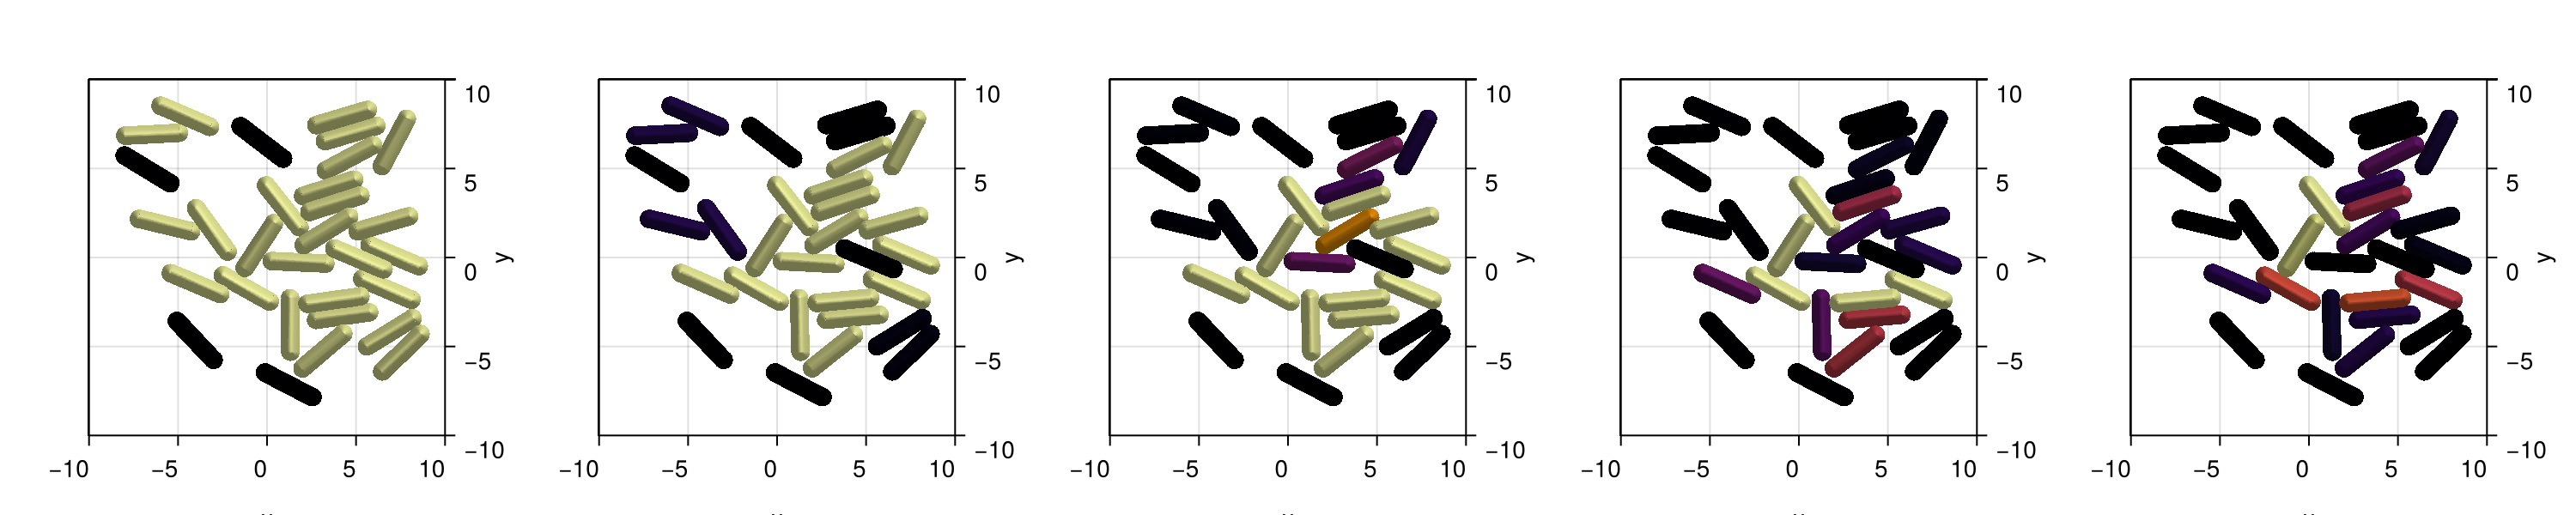

CairoMakie.Screen{IMAGE}


In [12]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotAgents2D!(
    ax,
    com[j][:x],
    com[j][:y],
    com[j][:d],
    com[j][:l],
    com[j][:theta],
    com[j][:pressure],
    colorrange = (0, maximum(com.pressure))
)

    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

In [13]:

function log_community_state(parameters::OrderedDict, t::Int, path::String = "parameters_QS_cap.txt")
    # Convert keys to strings so JSON can serialize them
    string_keys = Dict(string(k) => v for (k, v) in parameters)
    # Build entry
    entry = Dict("t" => t, "parameters" => string_keys)
    # Save as a JSON line
    open(path, "a") do io
        println(io, JSON.json(entry))
    end
end


function load_parameters_log(path::String = "parameters_QS_cap.txt")
    log = Dict{Int, OrderedDict{Symbol, Any}}()
    for line in eachline(path)
        entry = JSON.parse(line)
        t = entry["t"]
        raw_params = entry["parameters"]
        params = OrderedDict(Symbol(k) => v for (k, v) in raw_params)
        log[t] = params
    end
    times = sort(collect(keys(log)))
    com_array = [log[t] for t in times]
    return com_array, times
end



load_parameters_log (generic function with 2 methods)

In [14]:
steps=8000
saveEach=100
N=100
loadToPlatform!(com,preallocateAgents=N)
open("parameters_QS_cap.txt", "w") do f
    # clear file at start
end


for step in 1:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if  N - com.N[1] < 2*com.N[1]
            N = 4*com.N[1]
        end
        println("Step ",step, " N: ", com.N[1])
        log_community_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end


Step 100 N: 30
Step 200 N: 30
Step 300 N: 30
Step 400 N: 30
Step 500 N: 30
Step 600 N: 30
Step 700 N: 30
Step 800 N: 30
Step 900 N: 30
Step 1000 N: 30
Step 1100 N: 30
Step 1200 N: 30
Step 1300 N: 30
Step 1400 N: 30
Step 1500 N: 30
Step 1600 N: 30
Step 1700 N: 30
Step 1800 N: 30
Step 1900 N: 30
Step 2000 N: 30
Step 2100 N: 30
Step 2200 N: 30
Step 2300 N: 30
Step 2400 N: 30
Step 2500 N: 30
Step 2600 N: 30
Step 2700 N: 30
Step 2800 N: 30
Step 2900 N: 30
Step 3000 N: 30
Step 3100 N: 30
Step 3200 N: 30
Step 3300 N: 30
Step 3400 N: 30
Step 3500 N: 30
Step 3600 N: 30
Step 3700 N: 30
Step 3800 N: 30
Step 3900 N: 30
Step 4000 N: 30
Step 4100 N: 30
Step 4200 N: 30
Step 4300 N: 30
Step 4400 N: 30
Step 4500 N: 30
Step 4600 N: 30
Step 4700 N: 30
Step 4800 N: 30
Step 4900 N: 30
Step 5000 N: 30
Step 5100 N: 30
Step 5200 N: 30
Step 5300 N: 30
Step 5400 N: 30
Step 5500 N: 30
Step 5600 N: 30
Step 5700 N: 30
Step 5800 N: 30
Step 5900 N: 30
Step 6000 N: 30
Step 6100 N: 30
Step 6200 N: 30
Step 6300 N: 30
S

In [15]:
com_,times=load_parameters_log("parameters_QS_cap.txt")

(OrderedDict{Symbol, Any}[OrderedDict(:W => Any[1.7980562919894826e-10, 1.9546311487405666e-12, -6.4421843674635155e-12, 1.6533104622656268e-10, 0.0, -1.2771083879220309e-11, -2.524966236915702e-10, -1.137040409001078e-9, 1.0449593721375146e-10, -5.961125034608435e-11  …  9.944320869194488e-14, 0.0, -3.573595830166062e-10, -2.3680913805489014e-10, -1.9063527618140778e-10, 2.482337920864352e-10, -1.1984789076570096e-9, -8.741144950319758e-11, 0.0, 0.0], :fx => Any[-3.6533074312833194e-10, -9.793833224859115e-13, -2.540639718189794e-12, 2.754289806262033e-10, 0.0, -3.707241034048597e-11, -4.2922511787904765e-10, 4.791598900625776e-10, 3.2219139554120984e-11, 1.5379613725284436e-10  …  2.540639718189794e-12, 0.0, 3.1753073542777346e-10, 6.575740533233365e-10, 2.4547902408599134e-10, -2.72266542259977e-10, -2.0689334780260063e-10, -3.2219139554120984e-11, 0.0, 0.0], :x => Any[-1.1731721255313055, 6.879527421998479, -6.446119202808143, 7.147549962219017, 4.693153193203777, 4.247470092683788

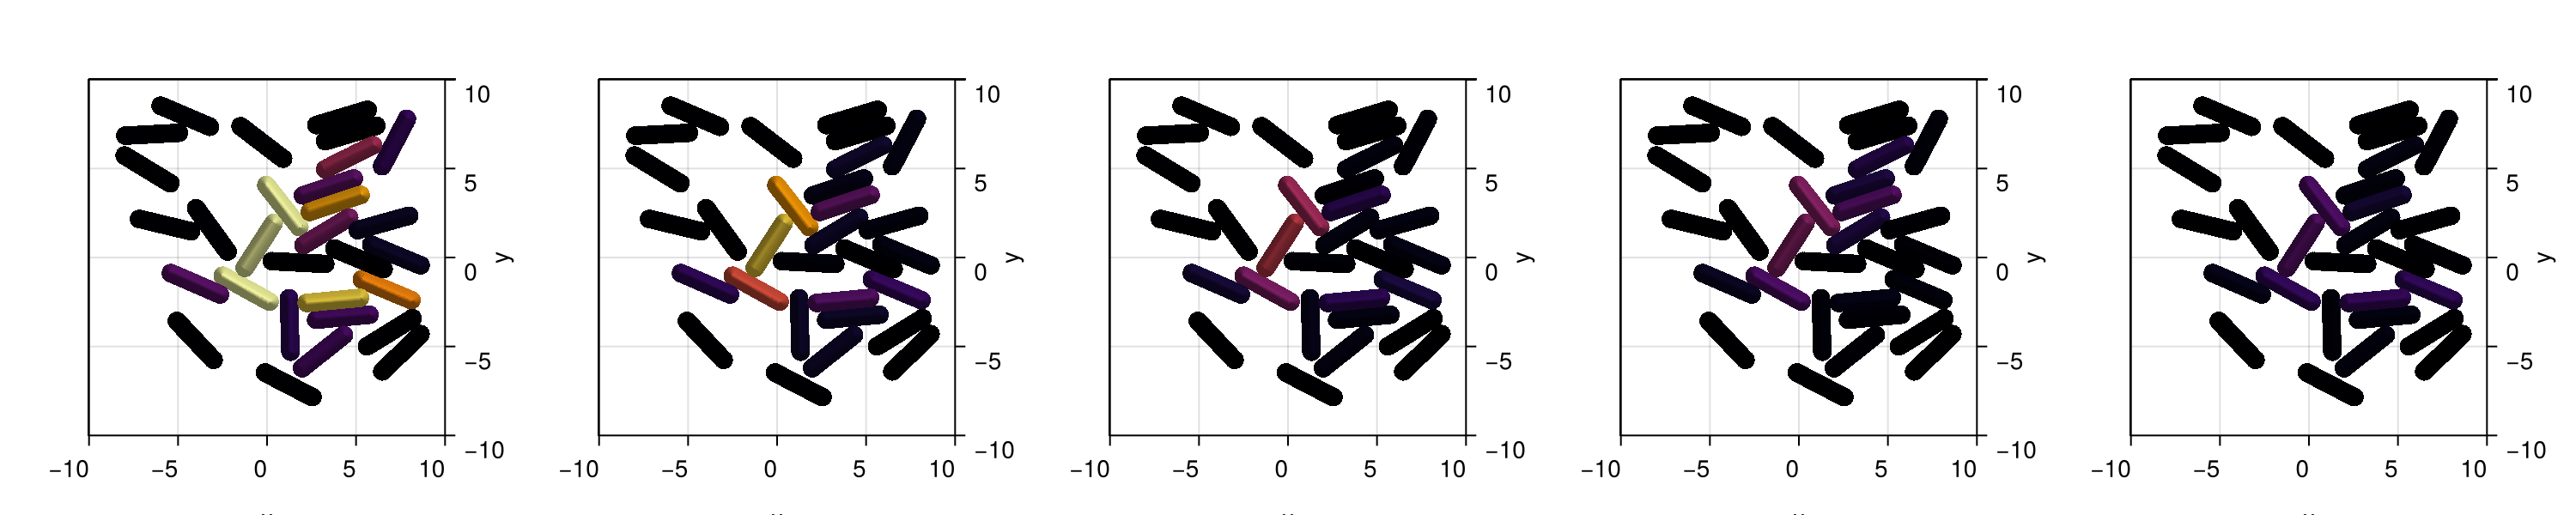

CairoMakie.Screen{IMAGE}


In [16]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com_)/4):length(com_);length(com_)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotAgents2D!(
    ax,
    com_[j][:x],
    com_[j][:y],
    com_[j][:d],
    com_[j][:l],
    com_[j][:theta],
    com_[j][:pressure],
    colorrange = (0, maximum((p[:pressure][1]) for p in com_))
)

    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

## Growth model

We construct over the forces model to add bacterial growth and cell division rules.

In [108]:
rods2dGrowth = ABM(2,
    baseModelInit = [rod2D],

    agent = Dict(
                :dg=> Float64, 
                :lTarget => Float64,
            ),

    model = Dict(
                :growth=>Float64,
                :σlTarget=>Float64,
                :lMax=>Float64,
                :D_q => Float64,
                :delta_q => Float64,
                :alpha_q => Float64, 
                :beta_q => Float64,
                :K_q=>Float64,
                :alpha_H => Float64, 
                :K_qH=>Float64,
                :K_dH=>Float64,
                :delta_H => Float64,
            ),
    
    medium = Dict(
        :q => Float64,        #Add a medium parameter
    ),

 
    agentODE = quote    
        dt(l) = l*growth #linear growth with growth dependent on the pressure over the cell
        dt(dg) = d + alpha_H * q^4/(K_qH^4+q^4) - delta_H*dg #linear growth with growth dependent on the pressure over the cell

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin
            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.repulsiveForces_rods(x,y,dg,l,theta,
                                    x[i2],y[i2],dg[i2],l[i2],theta[i2],eta, E)

            #Append the repulsive forces
            fx += Fijx
            fy += Fijy
            W += Wij
            
            pressure += sqrt(Fijx^2+Fijy^2)

            
        end
        #Equations
        dt(x) =  fx 
        dt(y) =  fy 
        dt(theta) =  W
    end,

    agentRule = quote #Bound cells
        #Add division
        if l > lTarget
            ww = CBMDistributions.uniform(-1,1)*1.E-3 #To add some random torque at division time
            # ww = 0 #To add some random torque at division time
            #Add a new cell
            @addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    W=ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget),
                    dg=dg,)
            #Add a second cell
            @addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    W=ww,
                    dg=dg)
            #Remove the old cell
            @removeAgent()
        end
        # Probability of releasing qs with a saturating function
        
        q += alpha_q + beta_q*q/(K_q + q) 
        

        # # Probability of releasing PGA with a saturating function
        # pg = q/(q+K_q)
        # if CBMDistributions.uniform(0, 1) < pg
        #     H += r_H
        # end
    end,

    #Medium dynamics with dirichlet conditions and a wall that is as oscillating source of material
    mediumODE=quote 
        if @mediumInside()
            dt(q) = D_q*(@∂2(1,q)+@∂2(2,q)) - delta_q*q 
        end

    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=CPU(),
    agentAlg=CBMIntegrators.Heun()
);

## Grow colony from one cell

In [168]:
1.E-3 /t 

3.6

In [198]:
com = Community(rods2dGrowth,
            N=1,
            dt=0.0001,
            simBox = [-100 100;-100 100.],
            NMedium=[100,100],
            );

#Natural units scales
m = 1.E3 #g
t = 1/(60*60) # h
d = 1.E6 #um


com.E=6* 1.E5 *m/(t^2*d) #Pa
com.eta=150 *m/(t^2*d) #Pa h

com.D_q = 1.E-11 *d^2/t #m^2/s

com.alpha_q = 0.5 #nM /h
com.delta_q = 500 #1/s
com.beta_q = 5 #1/s
com.K_q = 50

# com.delta_H = 0. 
# com.delta_H = 1.E-5 

# com.r_H = 1

com.dg=1.
com.alpha_H = 500.
com.K_qH = 20.  
com.delta_H = 1  

com.growth = 1
com.lMax = 4.     
com.σlTarget = 1. 
 
com.d = 1.        
com.l = 3.99      
com.lTarget = 4.  
# com.v = 2.E-2 


com.x = 0
com.y = 0
com.theta = 0;

In [199]:
com.simBox
com.NMedium

2-element Vector{Int64}:
 100
 100

In [201]:
Int(round(2/com.dt))

20000

In [ ]:
steps=Int(round(6/com.dt))
saveEach=steps/100
# steps=100000
# saveEach=10000
N=100 

loadToPlatform!(com,preallocateAgents=N)
open("parameters_QS_cap.txt", "w") do f
    # clear file at start
end

for step in 1:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if N - com.N[1] <= 0
                println("Step ",step, " N: ", com.N[1], " preallocateAgents: ", N)
                @warn "More agents than preallocateAgents, stopping simulation."
                break
        elseif   N - com.N[1]  < 4*com.N[1]
                N = 15*com.N[1]
        end 
        println("Step ",step, " N: ", com.N[1])
        log_community_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end
bringFromPlatform!(com)


Step 600 N: 2
Step 1200 N: 2
Step 1800 N: 2
Step 2400 N: 2
Step 3000 N: 2
Step 3600 N: 2
Step 4200 N: 2
Step 4800 N: 2
Step 5400 N: 2
Step 6000 N: 2
Step 6600 N: 2
Step 7200 N: 2
Step 7800 N: 2
Step 8400 N: 2
Step 9000 N: 2
Step 9600 N: 2
Step 10200 N: 2
Step 10800 N: 2
Step 11400 N: 3
Step 12000 N: 3
Step 12600 N: 4
Step 13200 N: 4
Step 13800 N: 4
Step 14400 N: 4
Step 15000 N: 4
Step 15600 N: 4
Step 16200 N: 4
Step 16800 N: 5
Step 17400 N: 6


In [ ]:

prev_steps=steps
steps=Int(round(9/com.dt))

loadToPlatform!(com,preallocateAgents=N)


for step in 1+prev_steps:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if N - com.N[1] <= 0
                println("Step ",step, " N: ", com.N[1], " preallocateAgents: ", N)
                @warn "More agents than preallocateAgents, stopping simulation."
                break
        elseif   N - com.N[1]  < 4*com.N[1]
                N = 15*com.N[1]
        end 
        println("Step ",step, " N: ", com.N[1])
        log_community_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end
bringFromPlatform!(com)


In [ ]:
com_load,times=load_parameters_log("parameters_QS_cap.txt")


(OrderedDict{Symbol, Any}[OrderedDict(:alpha_H => Any[500.0], :W => Any[-2.8843131943530486e-7, -2.884313134571942e-7], :fx => Any[-0.8068744945853461, 0.8068744862307842], :delta_q => Any[100.0], :x => Any[-1.307059409700867, 1.3070594090854926], :delta_H => Any[1.0], :σlTarget => Any[1.0], :theta => Any[-9.120422510406919e-8, -9.120422473587315e-8], :q => Any[Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Any[0.0, 1.499314459049771e-6, 3.0069655597550264e-6, 4.531266051436183e-6, 6.080479986001731e-6, 7.662796097388024e-6, 9.286298483261433e-6, 1.0958933738662027e-5, 1.2688473736048937e-5, 1.4482473305634743e-5  …  1.4424704367984475e-5, 1.2637816663025372e-5, 1.0915155308582021e-5, 9.24918735314018e-6, 7.632165850000274e-6, 6.056171645826428e-6, 4.513150111144627e-6, 2.9949435541313207e-6, 1.4933201172331833e-6, 0.0], Any[0.0, 3.0069656192684058e-6, 6.030721030177385e-6, 9.088008886973497e-6, 1.2195475723489887e-5, 1.53696

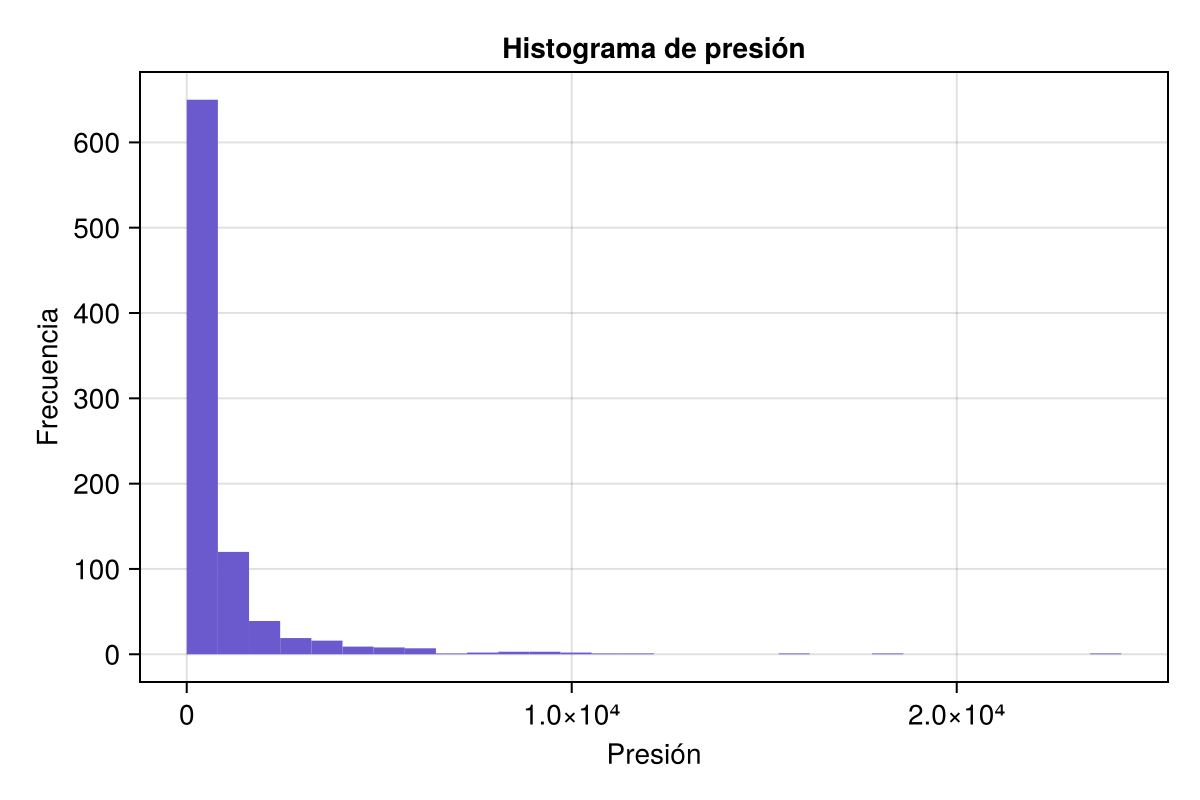

In [ ]:
# Elegimos un frame, por ejemplo el último
p = com_load[end][:pressure]

# Creamos la figura y el eje
fig = Figure(size = (600, 400))
ax = Axis(fig[1, 1]; xlabel = "Presión", ylabel = "Frecuencia", title = "Histograma de presión")

# Dibujamos el histograma
hist!(ax, p; bins = 30, color = :slateblue)

fig  # Esto muestra la figura en una ventana interactiva

In [ ]:
maximum(maximum(p -> maximum(p[:q]), com_load))

7.282396226081013

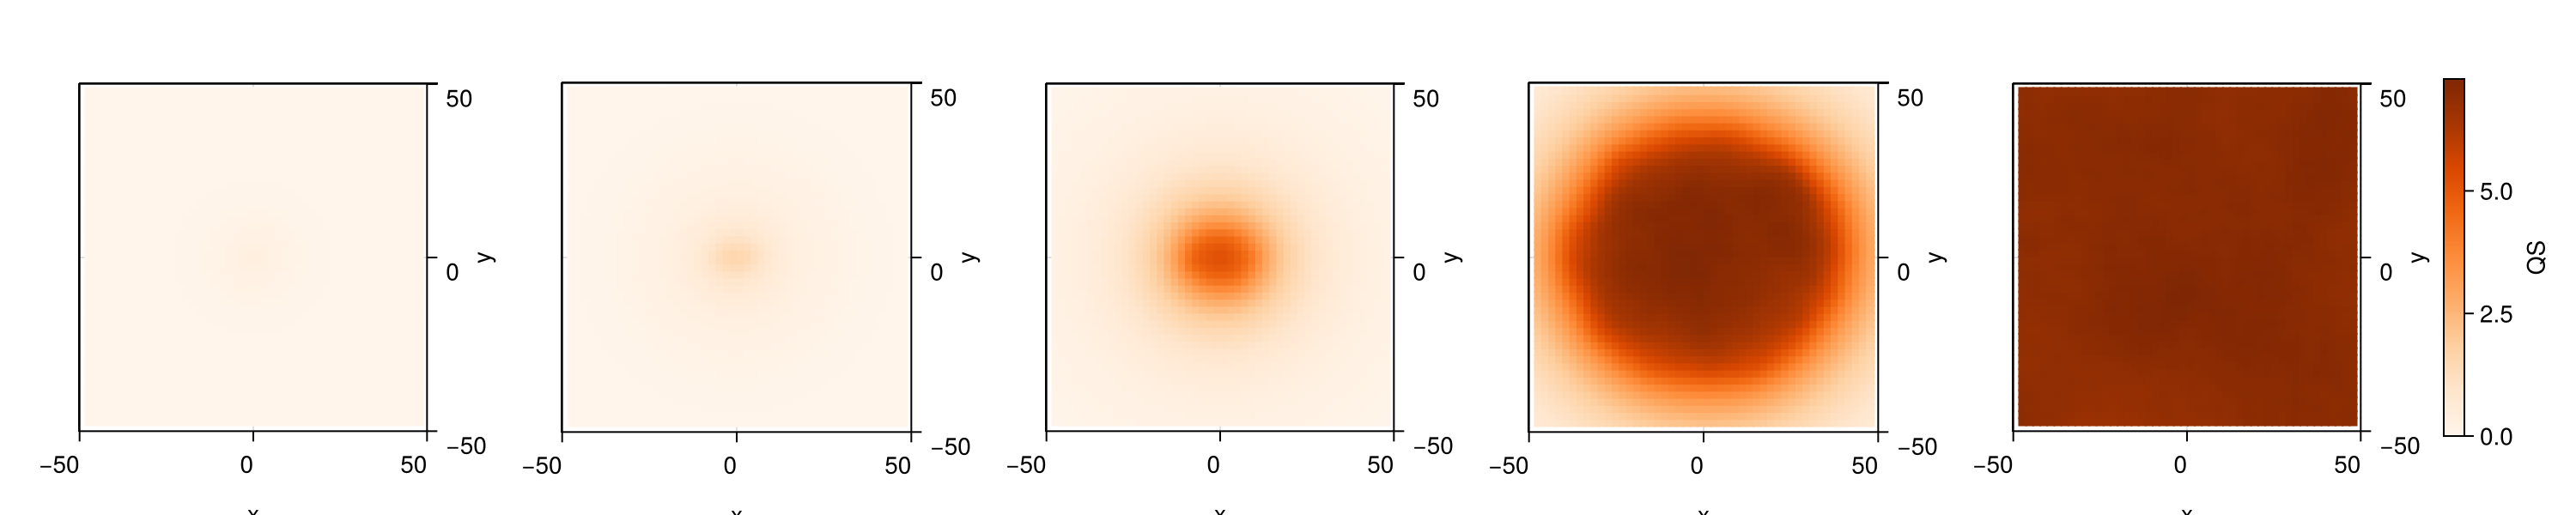

CairoMakie.Screen{IMAGE}


In [ ]:
# Colormap común y colorrange fijo
colormap = :Oranges
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))
# colorrange = (0.0,  0.01)



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    # plotAgents2D!(
    # ax,
    # com_load[j][:x],
    # com_load[j][:y],
    # com_load[j][:dg],
    # com_load[j][:l],
    # com_load[j][:theta],
    # com_load[j][:dg],
    # colormap=:Blues,
    # colorrange = colorrange
    # )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

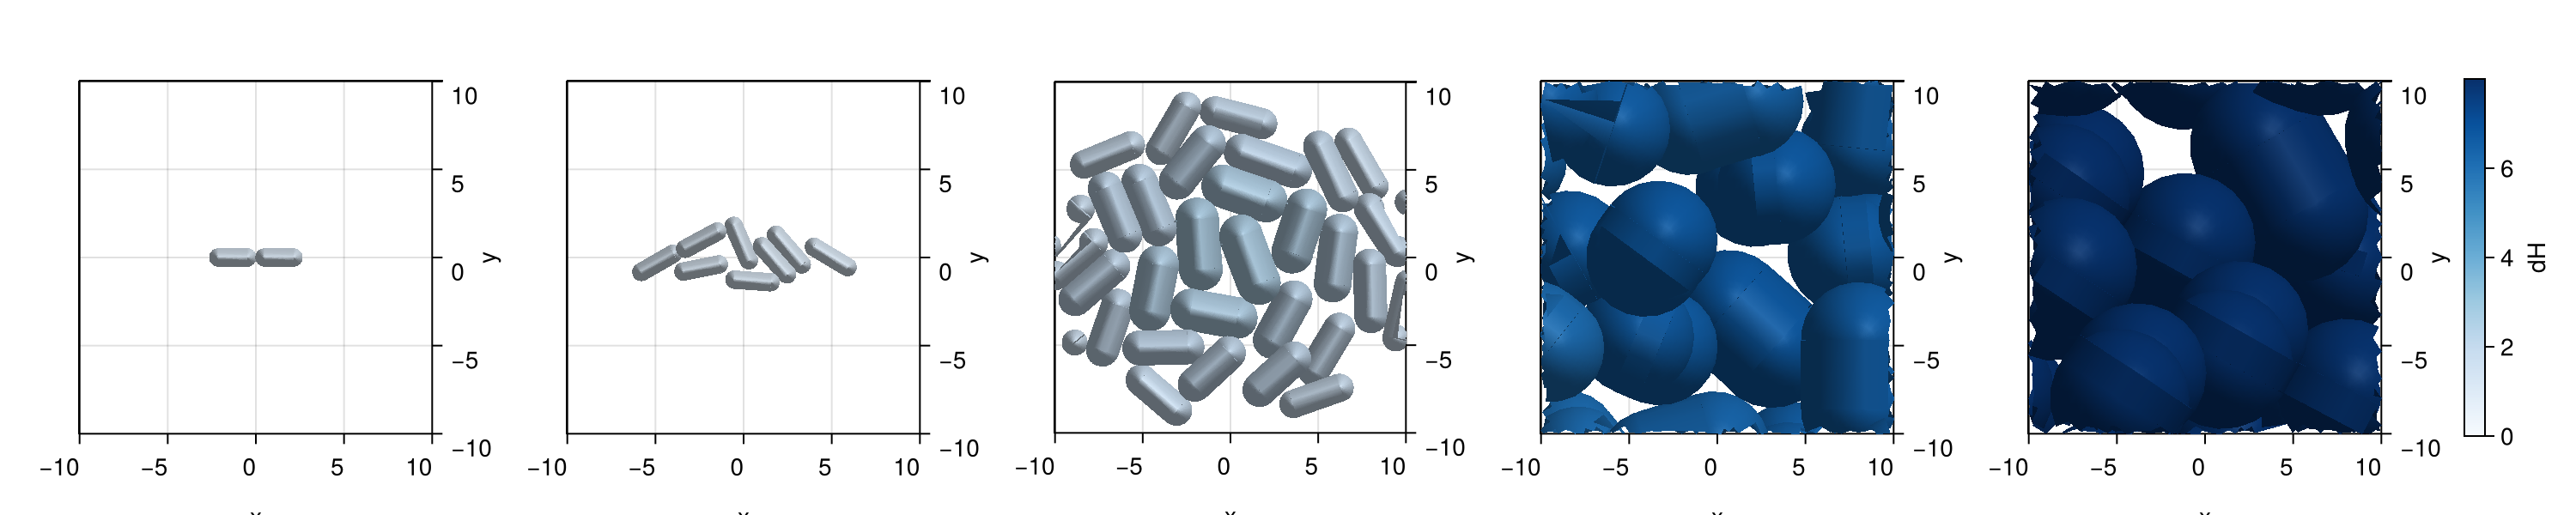

CairoMakie.Screen{IMAGE}


In [ ]:
# Colormap común y colorrange fijo
colormap = :Blues
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    # m = heatmap!(ax,
    #             range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
    #             range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
    #             Float64.(hcat(com_load[j][:q]...)),
    #             colormap = colormap,
    #             colorrange = colorrange
    #         )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:dg],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:dg],
    colormap=:Blues,
    colorrange = colorrange
    )

    xlims!(-10,10)
    ylims!(-10,10)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "dH"
)

display(fig)

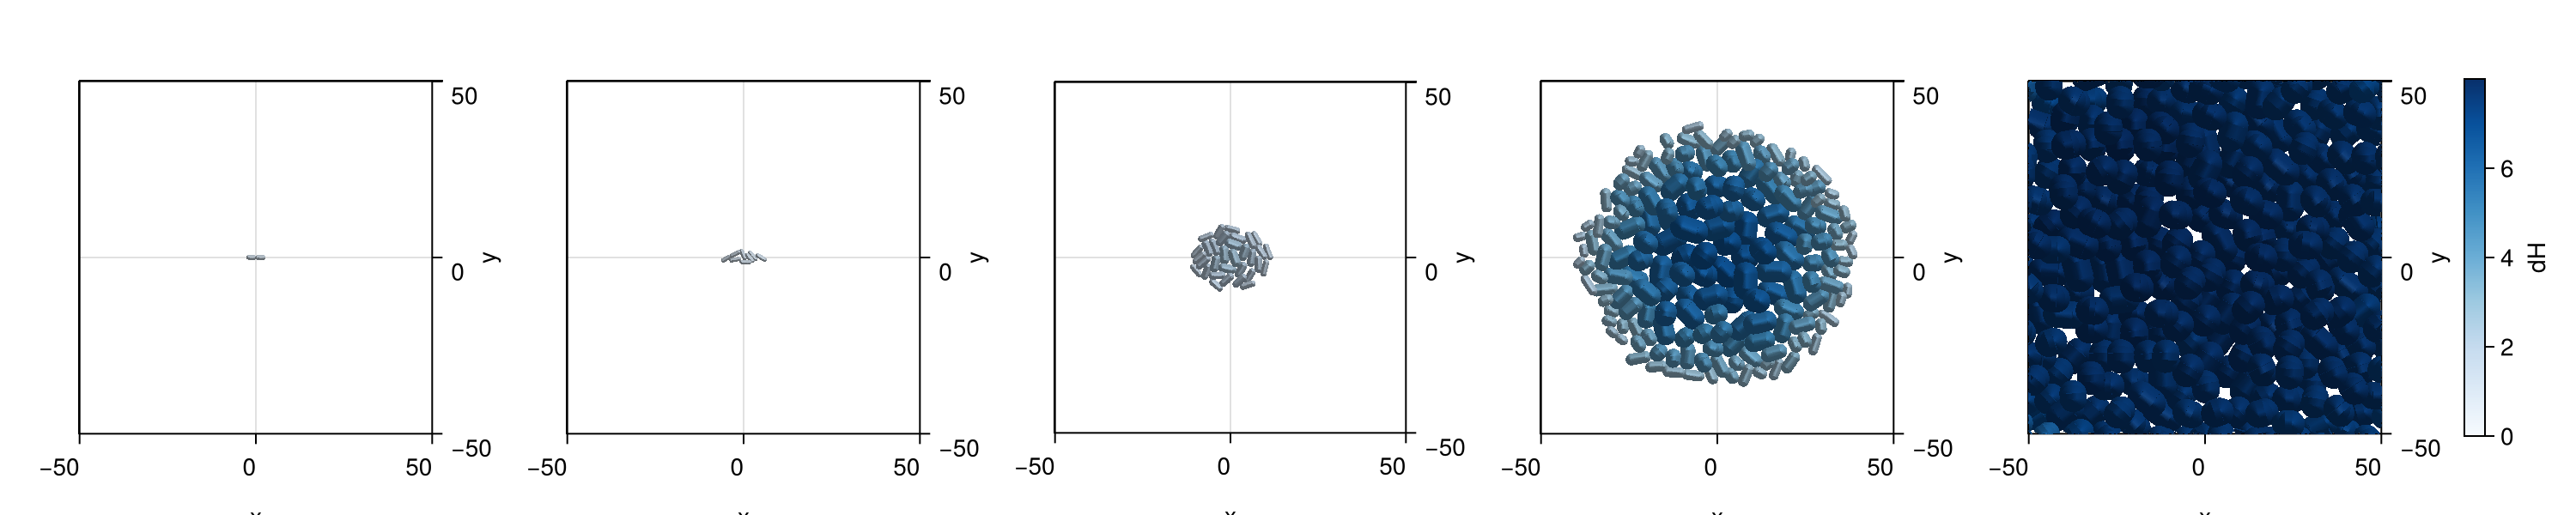

CairoMakie.Screen{IMAGE}


In [ ]:
# Colormap común y colorrange fijo
colormap = :Blues
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    # m = heatmap!(ax,
    #             range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
    #             range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
    #             Float64.(hcat(com_load[j][:q]...)),
    #             colormap = colormap,
    #             colorrange = colorrange
    #         )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:dg],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:dg],
    colormap=:Blues,
    colorrange = colorrange
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "dH"
)

display(fig)

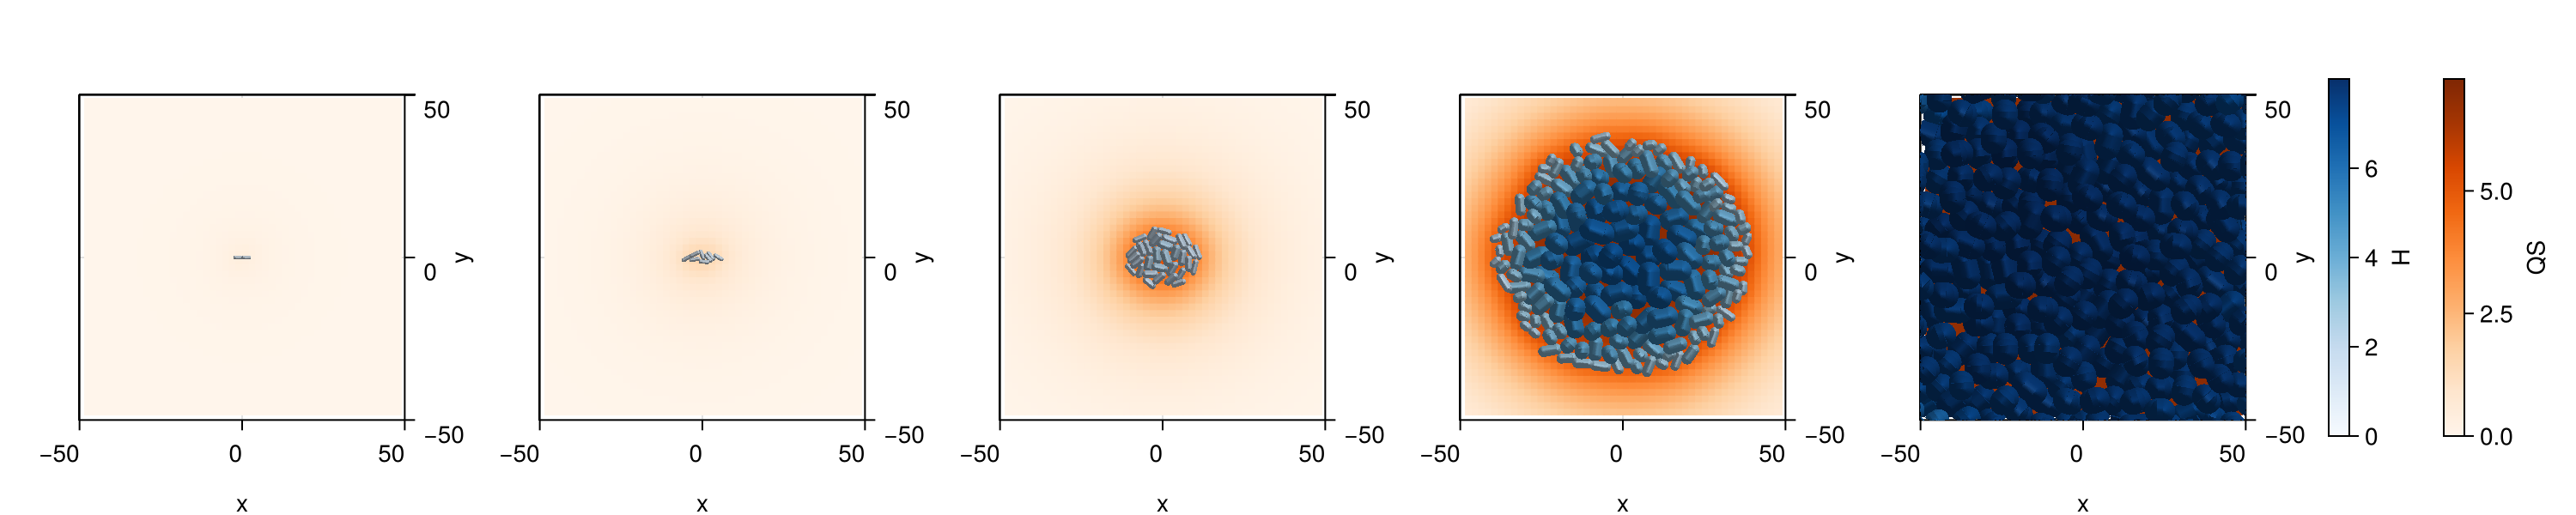

CairoMakie.Screen{IMAGE}


In [ ]:
# Colormap común y colorrange fijo
colormap = :Blues
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

# Colormap común y colorrange fijo
colormap_q = :Oranges
colorrange_q = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))

fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap_q,
                colorrange = colorrange_q
            )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:dg],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:dg],
    colormap=:Blues,
    colorrange = colorrange
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "H"
)
Colorbar(fig[1, length(js) + 2],
    colormap = colormap_q,
    colorrange = colorrange_q,
    label = "QS"
)

display(fig)

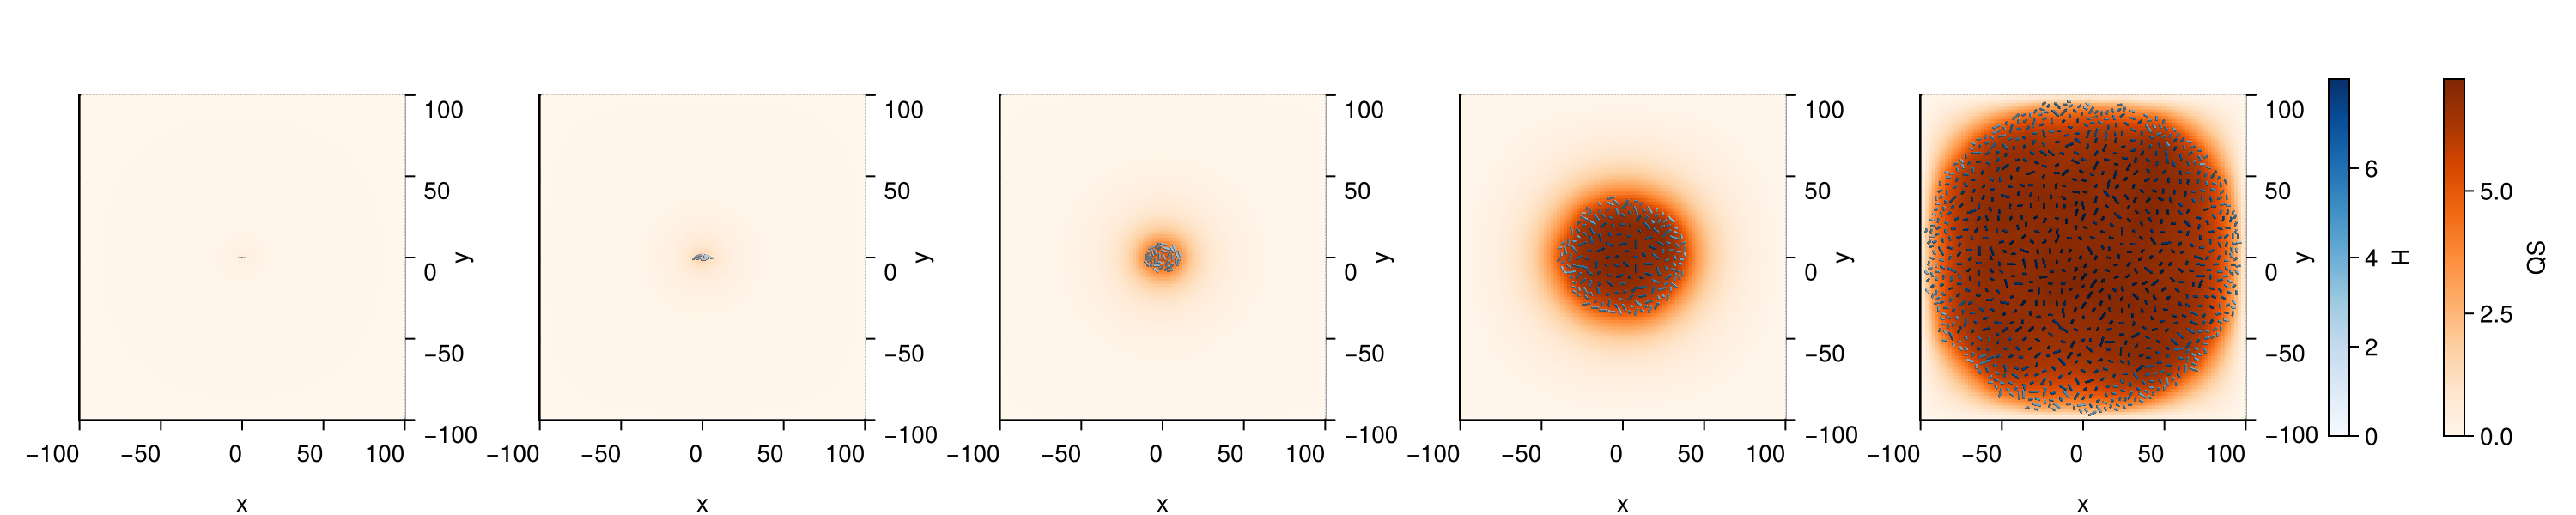

CairoMakie.Screen{IMAGE}


In [ ]:
# Colormap común y colorrange fijo
colormap = :Blues
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))

# Colormap común y colorrange fijo
colormap_q = :Oranges
colorrange_q = (0.0,  maximum(maximum(p -> maximum(p[:q]), com_load)))

fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
                Float64.(hcat(com_load[j][:q]...)),
                colormap = colormap_q,
                colorrange = colorrange_q
            )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:dg],
    colormap=:Blues,
    colorrange = colorrange
    )

    xlims!(-100,100)
    ylims!(-100,100)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "H"
)
Colorbar(fig[1, length(js) + 2],
    colormap = colormap_q,
    colorrange = colorrange_q,
    label = "QS"
)

display(fig)

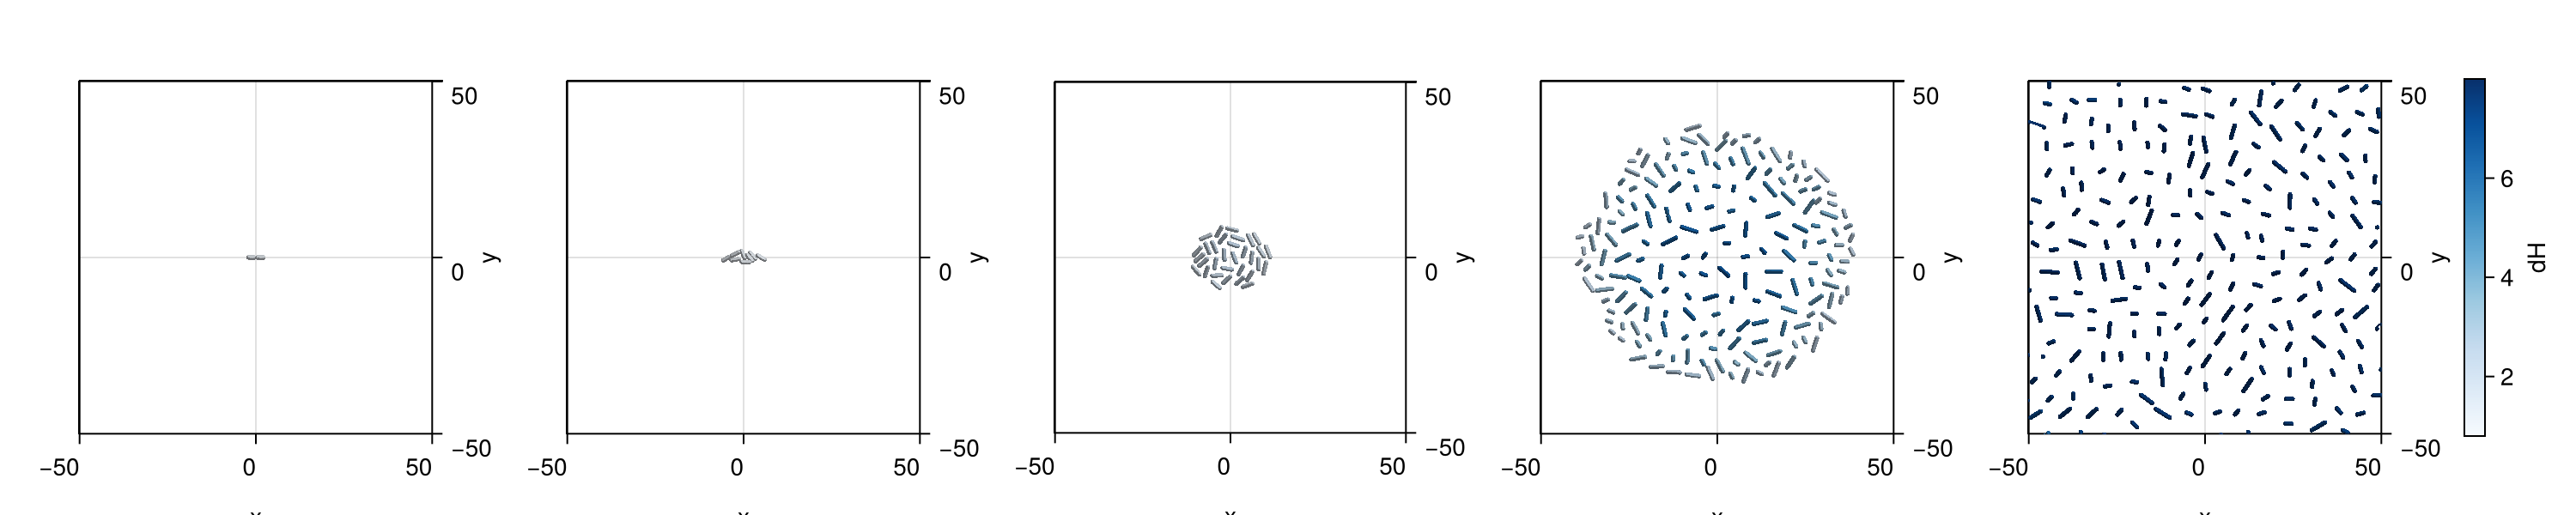

CairoMakie.Screen{IMAGE}


In [194]:
# Colormap común y colorrange fijo
colormap = :Blues
colorrange = (0.8,  maximum(maximum(p -> maximum(p[:dg]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    # m = heatmap!(ax,
    #             range(com.simBox[1,1],com.simBox[1,2],length=size(com.q)[1]),
    #             range(com.simBox[2,1],com.simBox[2,2],length=size(com.q)[1]),
    #             Float64.(hcat(com_load[j][:q]...)),
    #             colormap = colormap,
    #             colorrange = colorrange
    #         )
    

    plotAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:dg],
    colormap=:Blues,
    colorrange = colorrange,
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "dH"
)

display(fig)

In [ ]:

# Configuración general
colormap = :viridis
colorrange = (0,  maximum(maximum(p -> maximum(p[:q]), com_load)))


# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="QS")  # una vez



n_repeats = 1  # Número de veces que repetimos cada frame
framerate = 1  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap_QS.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real 

    if i % n_repeats == 0
        Makie.empty!(ax)
        # Preparar heatmap observable para actualizar luego
        x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.q)[1])
        y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.q)[2])
        z = copy(hcat(com_load[j][:q]...))  # inicializa con primer frame

        hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)
    end
    # Makie.empty!(ax)
    # # Preparar heatmap observable para actualizar luego
    # x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.q)[1])
    # y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.q)[2])
    # z = copy(hcat(com_load[j][:q]...))  # inicializa con primer frame

    # hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    # plotMixedAgents2D!(
    #     ax,
    #     com_load[j][:x],
    #     com_load[j][:y],
    #     com_load[j][:d],
    #     com_load[j][:l],
    #     com_load[j][:theta],
    #     com_load[j][:type],
    #     com_load[j][:pressure],
    #     colorrange = (0, 0.03)
    # )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"bacterias_cap_QS.mp4"

In [80]:

# Configuración general
colormap = Reverse(:Blues)
colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))


# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="dg")  # una vez

n_repeats = 1  # Número de veces que repetimos cada frame
framerate = 1  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real   
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    # x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.H)[1])
    # y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.H)[2])
    # z = copy(hcat(com_load[j][:H]...))  # inicializa con primer frame

    # hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colorrange = colorrange,
        colormap= colormap,
    )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"bacterias_cap.mp4"

In [39]:

# Configuración general
colormap = Reverse(:Blues)
colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))


# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="dg")  # una vez


n_repeats = 10  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap_zoom.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real  
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    # x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.H)[1])
    # y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.H)[2])
    # z = copy(hcat(com_load[j][:H]...))  # inicializa con primer frame

    # hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:d],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colorrange = colorrange,
        colormap= colormap,
    )


    xlims!(ax, -100, 100)
    ylims!(ax, -100, 100)
end


"bacterias_cap_zoom.mp4"

In [ ]:

# Configuración general
colormap = Reverse(:Blues)
colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))


# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="dg")  # una vez


n_repeats = 10  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap_pga.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real 
    Makie.empty!(ax)
    # Preparar heatmap observable para actualizar luego
    # x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.H)[1])
    # y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.H)[2])
    # z = copy(hcat(com_load[j][:H]...))  # inicializa con primer frame

    # hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:dg],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colorrange = colorrange,
        colormap = colormap
    )


    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"bacterias_cap_pga.mp4"

In [42]:
# Configuración general
colormap = Reverse(:Blues)
colorrange = (0,  maximum(maximum(p -> maximum(p[:dg]), com_load)))


# Crear figura y ejes
fig = Figure(size = (800, 600))
grid = fig[1, 1] = GridLayout()
ax = Axis(grid[1, 1]; aspect = DataAspect())
Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="dg")  # una vez



n_repeats = 10  # Número de veces que repetimos cada frame
framerate = 10  # 10 fps → cada frame se mantiene 1 segundo

Makie.record(fig, "bacterias_cap_pga_zoom.mp4", 1:length(com_load) * n_repeats; framerate = framerate) do i
    j = ceil(Int, i / n_repeats)  # Frame real

    Makie.empty!(ax)

    plotAgents2D!(
        ax,
        com_load[j][:x],
        com_load[j][:y],
        com_load[j][:dg],
        com_load[j][:l],
        com_load[j][:theta],
        com_load[j][:dg],
        colormap = colormap,
        colorrange = colorrange
    )

    xlims!(ax, -100, 100)
    ylims!(ax, -100, 100)
end


"bacterias_cap_pga_zoom.mp4"